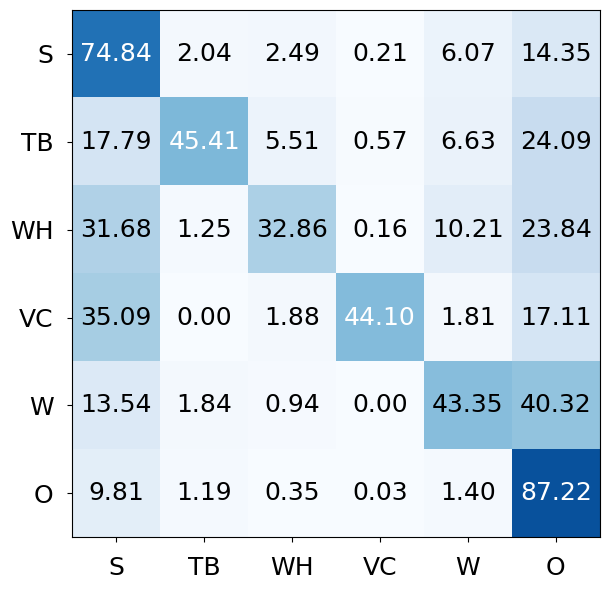

In [14]:
# Multimodal Confusion Matrix Visualization Pipeline
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix

# Configuration
PROJECT_ROOT = Path("..")
MULTI_DIR = PROJECT_ROOT / "Results/Experiment_Result/Model_Preds/Multimodal"
FINETUNE_DIR = PROJECT_ROOT / "Results/Experiment_Result/Model_Preds/finetune_6class_other_front"
FINETUNE_OTHER_DIR = PROJECT_ROOT / "Results/Experiment_Result/Model_Preds/finetune_6class_other_front_other"
CM_OUTPUT_DIR = PROJECT_ROOT / "Results/Experiment_Result/confusion_matrix/finetune_6class_other/front"

CLASS_NAMES = ['Shower','Tooth_brushing','Washing_hands','Vacuum_Cleaner','Wiping','Other']
CLASS_LABELS= ['S','TB','WH','VC','W','O']
METHOD = 'full'
TIME_SEC = 420

# Ensure output directory
CM_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def load_predictions(folder: Path, include_other: bool=False) -> (list, list):
    """
    Aggregate y_true and y_pred from CSV files in given folder.
    If include_other=True, only include rows where y_true=='Other'.
    Else, include y_true!='Other'.
    """
    y_true, y_pred = [], []
    for pid_dir in folder.iterdir():
        if not pid_dir.is_dir(): continue
        csvs = list((pid_dir / f"finetuned_{METHOD}_{TIME_SEC}").glob('*.csv'))
        if not csvs: continue
        df = pd.read_csv(csvs[0])
        if include_other:
            df = df[df['y_true']=='Other']
        else:
            df = df[df['y_true']!='Other']
        y_true.extend(df['y_true'].tolist())
        y_pred.extend(df['y_pred'].tolist())
    return y_true, y_pred

def plot_confusion_matrix(y_true: list, y_pred: list, out_path: Path, title: str=None):
    cm = confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    cm_pct = (cm.astype(float) / cm.sum(axis=1)[:,None]) * 100
    cm_pct = np.nan_to_num(cm_pct)
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=100)
    ax.set_xticks(range(len(CLASS_LABELS)))
    ax.set_yticks(range(len(CLASS_LABELS)))
    ax.set_xticklabels(CLASS_LABELS, fontsize=18)
    ax.set_yticklabels(CLASS_LABELS, fontsize=18)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    if title:
        ax.set_title(title, pad=20, fontsize=18)
    thresh = cm_pct.max()/2
    for i in range(cm_pct.shape[0]):
        for j in range(cm_pct.shape[1]):
            color = 'white' if cm_pct[i,j]>thresh else 'black'
            ax.text(j, i, f"{cm_pct[i,j]:.2f}", ha='center', va='center', color=color, fontsize=18)
    plt.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)
    print(f"Saved confusion matrix to {out_path}")

if __name__=='__main__':
    # Multimodal combined
    y_t_all, y_p_all = load_predictions(MULTI_DIR, include_other=False)
    plot_confusion_matrix(
        y_t_all, y_p_all,
        MULTI_DIR / 'confusion_multimodal.png',
        title='Multimodal Overall'
    )

    # Fine-tune split: existing (non-Other)
    y_t_main, y_p_main = load_predictions(FINETUNE_DIR, include_other=False)
    # Fine-tune other only
    y_t_other, y_p_other = load_predictions(FINETUNE_OTHER_DIR, include_other=True)
    # Combine
    y_t_comb = y_t_main + y_t_other
    y_p_comb = y_p_main + y_p_other
    plot_confusion_matrix(
        y_t_comb, y_p_comb,
        CM_OUTPUT_DIR / f'cm_{METHOD}_{TIME_SEC}.png',
        title=f'Fine-tune {METHOD} @ {TIME_SEC}s'
    )